In [1]:
import numpy as np
import pandas as pd
from neural_net.loss import CrossEntropyLoss
from neural_net.modules import NeuralLayer
from neural_net.activations import Relu, Sigmoid
from neural_net.networks import ANN
from neural_net.base import Tensor
from PIL import Image
import io
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [2]:
splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["train"])

In [3]:
df.head(2)

,image,label
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,5
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0


In [4]:
to_int = lambda x: 1 if x else 0
one_hot = pd.get_dummies(df['label']).map(to_int)

df = df.drop(columns='label').join(one_hot)

df.head(2)

,image,0,1,2,3,4,5,6,7,8,9
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,0,0,0,0,1,0,0,0,0
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,0,0,0,0,0,0,0,0,0


In [5]:
class DataSet:
    def __init__(self, df:pd.DataFrame, batch_size=32, shuffle=True, img_shape=(28,28), transform=None):
        self.df = df
        self.labels = df.columns.drop('image')
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(df)
        self.indices = np.arange(self.num_samples)
        self.current_idx = 0  # Keeps track of batch index
        self.img_shape = img_shape
        self.transform = transform

        if self.shuffle:
            np.random.shuffle(self.indices)  # Shuffle data at the start

    def __iter__(self):
        self.current_idx = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self
    
    def __len__(self):
        n = self.num_samples//self.batch_size
        if self.num_samples%self.batch_size != 0:
            n+=1
        return n

    def __next__(self) -> tuple[Tensor, Tensor]:
        if self.current_idx >= self.num_samples:
            raise StopIteration  # Stop when all batches are processed

        if self.current_idx + self.batch_size < self.num_samples:
            next_idx = self.current_idx + self.batch_size
        else:
            next_idx = self.num_samples
        # Get batch indices
        batch_indices = self.indices[self.current_idx: next_idx]
        
        # Slice data for the batch
        X_batch = np.zeros((len(batch_indices), self.img_shape[0]*self.img_shape[1]))
        for i, b in enumerate(batch_indices):
            img = Image.open(io.BytesIO(self.df.iloc[b].image['bytes']))
            X_batch[i,:] = np.array(img, dtype=np.float32).flatten()/256
        if self.transform != None:
            X_batch = self.transform(X_batch)
        y_batch = self.df[self.labels].iloc[batch_indices].to_numpy(dtype=np.float32)

        # Move to the next batch
        self.current_idx = next_idx
        
        return Tensor(X_batch), Tensor(y_batch)

Split into train, test and validation set

In [6]:
# add some random noise in the training to help stabilizing net and avoid overfitting
def train_transf(x):
    return x + np.random.randn(*x.shape)*0.1

n_samples = len(df)

n_train = int(0.75*n_samples)
n_test = int( (n_samples-n_train)*0.7 )
n_val = n_samples-n_train-n_test

df_train = df[:n_train]
df_test = df[n_train: n_train+n_test]
df_val = df[n_train+n_test: n_train+n_test+n_val]

train_set = DataSet(df_train, transform=train_transf)
test_set = DataSet(df_test)
val_set = DataSet(df_val)

Set up the neural network

In [7]:
num_epochs = 10
lr = 1e-3
loss = CrossEntropyLoss()
in_dim = 28*28
out_dim = len( train_set.labels )

nn = ANN(loss, weight_decay=1E-4)
nn.layers.extend([
    NeuralLayer(in_dim, 256),
    Relu(),
    NeuralLayer(256, 128),
    Relu(),
    NeuralLayer(128, 64),
    Relu(),
    NeuralLayer(64, out_dim),
]
)

In [8]:
def accuracy(logits, y):
    sigma = Sigmoid()
    probs = sigma(logits)
    predictions = np.argmax(probs, axis=-1)
    reals = np.argmax(y, axis=-1)
    correct = 0
    for i in range(reals.shape[0]):
        if reals[i] == predictions[i]:
            correct += 1
    return correct

### Train

In [9]:
train_losses, test_losses, test_accuracies = [], [], []
best_test_loss = float('inf')
best_model = copy.deepcopy(nn)
for epoch in range(num_epochs):
    train_loss, test_loss, test_accuracy = 0,0,0
    # train
    nn.train = True
    for i,data in enumerate(tqdm(train_set)):
        nn.zero_grads()
        x, y = data
        y_hat = nn(x)
        train_loss += nn.get_loss(y_hat, y)
        nn.backward()
        nn.step(lr)
    train_losses.append(train_loss/len(train_set))
    
    nn.train = False
    for i,data in enumerate(tqdm(test_set)):
        x, y = data
        y_hat = nn(x)
        test_accuracy += accuracy(y_hat, y)
        test_loss += nn.get_loss(y_hat, y)
    test_losses.append(test_loss/len(test_set))
    test_accuracies.append( test_accuracy/test_set.num_samples )

    print(f"epoch {epoch+1:2.0f} \t train: {train_losses[-1]:3.3f}\t test: {test_losses[-1]:3.3f} \t accuracy {100*test_accuracies[-1]:3.3f}%")

    # save best model
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        best_model = copy.deepcopy(nn)

100%|██████████| 329/329 [00:01<00:00, 308.89it/s]


epoch  1 	 train: 0.821	 test: 0.399 	 accuracy 87.971%


100%|██████████| 329/329 [00:00<00:00, 344.35it/s]


epoch  2 	 train: 0.379	 test: 0.310 	 accuracy 90.629%


100%|██████████| 329/329 [00:00<00:00, 356.61it/s]


epoch  3 	 train: 0.301	 test: 0.260 	 accuracy 92.210%


100%|██████████| 329/329 [00:01<00:00, 291.81it/s]


epoch  4 	 train: 0.258	 test: 0.235 	 accuracy 93.095%


100%|██████████| 329/329 [00:01<00:00, 319.48it/s]


epoch  5 	 train: 0.232	 test: 0.225 	 accuracy 93.352%


100%|██████████| 329/329 [00:00<00:00, 334.76it/s]


epoch  6 	 train: 0.213	 test: 0.213 	 accuracy 93.619%


100%|██████████| 329/329 [00:00<00:00, 329.45it/s]


epoch  7 	 train: 0.196	 test: 0.196 	 accuracy 94.248%


100%|██████████| 329/329 [00:00<00:00, 350.49it/s]


epoch  8 	 train: 0.183	 test: 0.192 	 accuracy 94.238%


100%|██████████| 329/329 [00:00<00:00, 341.61it/s]


epoch  9 	 train: 0.174	 test: 0.187 	 accuracy 94.267%


100%|██████████| 329/329 [00:00<00:00, 355.29it/s]

epoch 10 	 train: 0.163	 test: 0.179 	 accuracy 94.657%


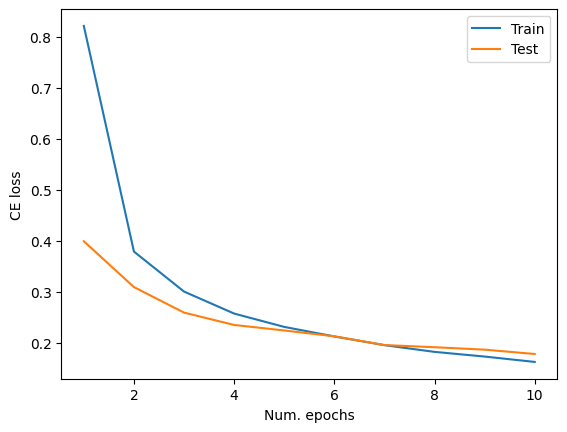

In [10]:
plt.plot(range(1,num_epochs+1), train_losses, label="Train")
plt.plot(range(1,num_epochs+1), test_losses, label="Test")
plt.xlabel('Num. epochs')
plt.ylabel('CE loss')
plt.legend()
plt.show()

### Validation

In [11]:
best_model.train = False
val_accuracy = 0
for batch in val_set:
    i += 1
    x, y = batch
    y_hat = best_model(x)
    val_accuracy += accuracy(y_hat, y)
print(f"accurcay on validation set {100* (val_accuracy/val_set.num_samples) :3.3f}%")

accurcay on validation set 96.622%


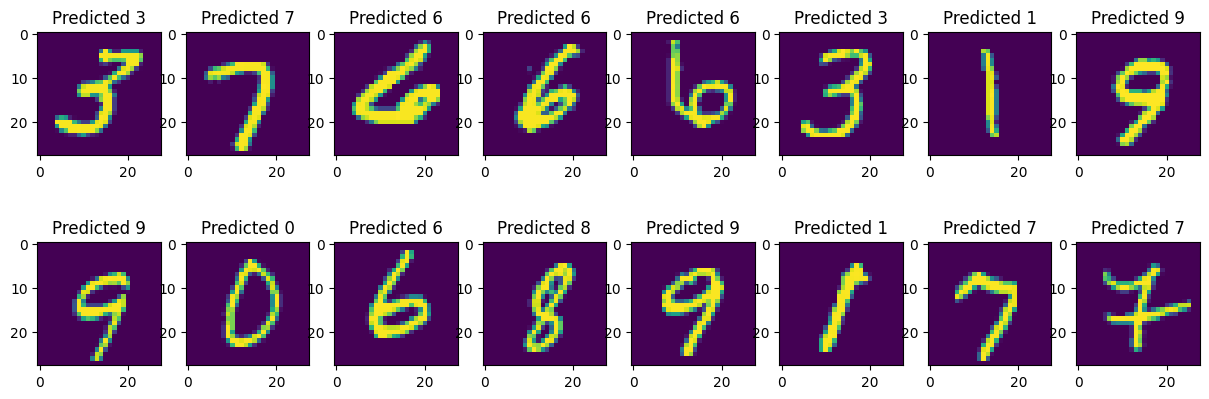

In [12]:
_, axs = plt.subplots(2, 8, figsize=(15, 5))

val_set.current_idx = 1
batch = next(val_set)
x, y = batch
logits = best_model(x)

# predict class
sigma = Sigmoid()
probs = sigma(logits)
predictions = np.argmax(probs, axis=-1)

axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(x[i].reshape(28,28))
    ax.title.set_text(f'Predicted {predictions[i]}')
